In [52]:
import random
import numpy as np
import gym
import collections
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings

In [53]:
class replay_buffer():
    def __init__(self, capacity):
        self.__buffer = collections.deque(maxlen = capacity)

    def add(self, state, action, reward, next_state, done):
        self.__buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        transitions = random.sample(self.__buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.__buffer)
    
class Qnet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))
    

In [54]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.qnet = Qnet(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr = learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update # 目标网络更新频率

        self.target_update_cnt = 0
        
    def epsilon_greeedy(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype = torch.float).to(self.device)
            action = self.qnet(state).argmax().item()
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict["state"], dtype = torch.float).to(self.device)
        actions = torch.tensor(transition_dict["action"]).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict["reward"]).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict["next_state"], dtype = torch.float).to(self.device)
        dones = torch.tensor(transition_dict["done"]).view(-1, 1).to(self.device)

        q_val = self.qnet(states).gather(1, actions)
        max_next_q_val = self.target_net(next_states).max(1)[0].view(-1, 1)

        q_target = rewards + self.gamma * max_next_q_val * torch.logical_not(dones)
        dqn_loss = torch.mean(F.mse_loss(q_val, q_target))

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.target_update_cnt % self.target_update:
            self.target_net.load_state_dict(self.qnet.state_dict())
            
        self.target_update_cnt += 1


In [55]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


Iteration 9: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s, episode=500, return=173.400]


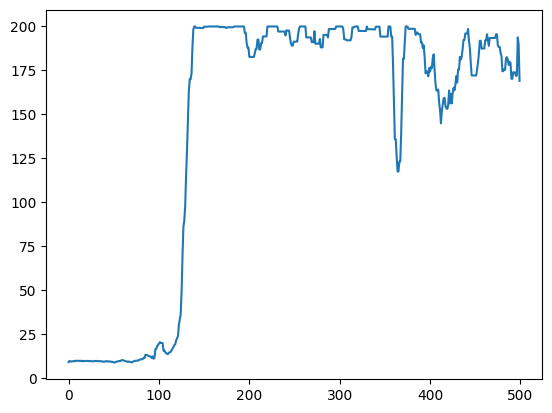

In [56]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64

env_name = 'CartPole-v0'
env = gym.make(env_name)

replay_buffer = replay_buffer(buffer_size)

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update)

history = []

# --------------------------------train-------------------------------------------#

for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for episode in range(int(num_episodes / 10)):
            state = env.reset()
            done = False
            episode_reward_total = 0
            while not done:
                action = agent.epsilon_greeedy(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_reward_total += reward

                if replay_buffer.size() > minimal_size:
                    bs_state, bs_action, bs_reward, bs_next_state, bs_done = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'state' : bs_state,
                        'action' : bs_action,
                        'reward' : bs_reward,
                        'next_state' : bs_next_state,
                        'done' : bs_done
                    }
                    agent.update(transition_dict)
            
            history.append(episode_reward_total)
            if (episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + episode + 1),
                    'return':
                    '%.3f' % np.mean(history[-10:])
                })
            pbar.update(1)

history = moving_average(history, 9)
plt.plot(history)
plt.show()
            